In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import perf_counter

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
!gdown 1r8BvjiakPswIqnlZRYfRE47SgwYXLekB

Downloading...
From: https://drive.google.com/uc?id=1r8BvjiakPswIqnlZRYfRE47SgwYXLekB
To: /content/Flower.zip
100% 236M/236M [00:01<00:00, 197MB/s]


In [3]:
!unzip Flower

Archive:  Flower.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_dc211569b0.jpg  
  inflating: flowers/daisy/10555826524_423eb8bf71_n.jpg  
  inflating: flo

In [4]:
image_dir = Path('/content/flowers')
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

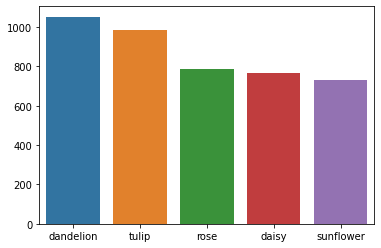

In [5]:
sns.barplot(x=image_df.Label.value_counts().index, y=image_df.Label.value_counts().values)
plt.show()

In [6]:
train_ds, test_ds = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

In [7]:
train_ds = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(train_ds,
                                                                 x_col='Filepath',
                                                                 y_col='Label',
                                                                 target_size=(224, 224),
                                                                 color_mode='rgb',
                                                                 class_mode='categorical',
                                                                 batch_size=32)
test_ds = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(test_ds,
                                                                 x_col='Filepath',
                                                                 y_col='Label',
                                                                 target_size=(224, 224),
                                                                 color_mode='rgb',
                                                                 class_mode='categorical',
                                                                 batch_size=32)

Found 3453 validated image filenames belonging to 5 classes.
Found 864 validated image filenames belonging to 5 classes.


##Train my own model

In [8]:
def my_model(summary=False):
  input = layers.Input(shape=(224,224,3))

  x = layers.Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu')(input)
  x = layers.Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.3)(x)

  x = layers.Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = layers.Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.3)(x)

  x = layers.Conv2D(128, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = layers.Conv2D(128, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = layers.Conv2D(128, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.4)(x)

  x = layers.Conv2D(256, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.Conv2D(256, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.Conv2D(256, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.4)(x)

  x = layers.Conv2D(512, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.Conv2D(512, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.Conv2D(512, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.5)(x)

  x = layers.Flatten()(x)
  x = layers.Dense(1024, kernel_initializer='he_normal', activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dense(1024, kernel_initializer='he_normal', activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.5)(x)

  output = layers.Dense(5, activation='softmax')(x)

  model = Model(input, output)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    print(model.summary())
    
  return model

In [9]:
model_own = my_model(summary=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 110, 110, 64)      36928     
                                                             

In [10]:
start_tra = perf_counter()
history = model_own.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 49s 301ms/step - loss: 2.2151 - accuracy: 0.2968 - val_loss: 1.3894 - val_accuracy: 0.3796
Epoch 2/20
108/108 [==============================] - 29s 269ms/step - loss: 1.7526 - accuracy: 0.3354 - val_loss: 2.2878 - val_accuracy: 0.4086
Epoch 3/20
108/108 [==============================] - 30s 273ms/step - loss: 1.6436 - accuracy: 0.3446 - val_loss: 1.9457 - val_accuracy: 0.3461
Epoch 4/20
108/108 [==============================] - 30s 275ms/step - loss: 1.5886 - accuracy: 0.3449 - val_loss: 1.5192 - val_accuracy: 0.4306
Epoch 5/20
108/108 [==============================] - 30s 278ms/step - loss: 1.5352 - accuracy: 0.3710 - val_loss: 1.6338 - val_accuracy: 0.1829
Epoch 6/20
108/108 [==============================] - 34s 315ms/step - loss: 1.5384 - accuracy: 0.3545 - val_loss: 1.3630 - val_accuracy: 0.3229
Epoch 7/20
108/108 [==============================] - 30s 279ms/step - loss: 1.4742 - accuracy: 0.3669 - val_loss: 1.5187 - val_ac

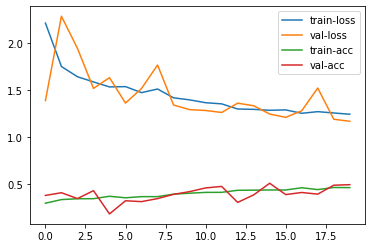

In [11]:
plt.plot(history.history['loss'], label='train-loss')
plt.plot(history.history['val_loss'], label='val-loss')
plt.plot(history.history['accuracy'], label='train-acc')
plt.plot(history.history['val_accuracy'], label='val-acc')
plt.legend()

In [12]:
score_own = model_own.evaluate(test_ds)[1]

27/27 [==============================] - 3s 112ms/step - loss: 1.1693 - accuracy: 0.4942


## TransferLearning Part 1 (Just change the last Dense layer--->to change the number of classes)

Notice that we can not use: vgg_model = VGG16(weights='imagenet',input_shape=(224,224,3), include_top=True, classes=10) because the model just accept imagenet weights when we don't change the number of its classes(1000); otherwise we should train the model on our dataset without imagenet weights and just use VGG's architecture (which is not useful beacuse of the time and low amount of data)

In [13]:
# lest's first look at the complete VGG16 architecture
mobile_test = MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=True)
mobile_test.summary()

14536120/14536120 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
              

In [17]:
def Mobile_1(summary=False):
  mobile_model = MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=True)

  for layer in mobile_model.layers[:]:
      layer.trainable = False
  # this part is just like: vgg_model.trainable = False

  # last fully connected layer before Dense(1000) in image net
  output = output = mobile_model.layers[-2].output
  # output = layers.Flatten(name='new_flatten')(output)
  output = layers.Dense(5, activation='softmax')(output)

  mobile_model = Model(mobile_model.input, output)
  mobile_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    print(mobile_model.summary())

  return mobile_model

In [18]:
mobile_1 = Mobile_1(summary=True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [19]:
start_tra = perf_counter()
history_1 = mobile_1.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 18s 141ms/step - loss: 0.7408 - accuracy: 0.7231 - val_loss: 0.4862 - val_accuracy: 0.8229
Epoch 2/20
108/108 [==============================] - 21s 197ms/step - loss: 0.3844 - accuracy: 0.8714 - val_loss: 0.4137 - val_accuracy: 0.8565
Epoch 3/20
108/108 [==============================] - 14s 133ms/step - loss: 0.3108 - accuracy: 0.8986 - val_loss: 0.3961 - val_accuracy: 0.8611
Epoch 4/20
108/108 [==============================] - 15s 139ms/step - loss: 0.2687 - accuracy: 0.9166 - val_loss: 0.3857 - val_accuracy: 0.8657
Epoch 5/20
108/108 [==============================] - 15s 143ms/step - loss: 0.2339 - accuracy: 0.9264 - val_loss: 0.4002 - val_accuracy: 0.8611
Epoch 6/20
108/108 [==============================] - 14s 129ms/step - loss: 0.2091 - accuracy: 0.9348 - val_loss: 0.3876 - val_accuracy: 0.8681
Epoch 7/20
108/108 [==============================] - 16s 144ms/step - loss: 0.1890 - accuracy: 0.9444 - val_loss: 0.3871 - val_ac

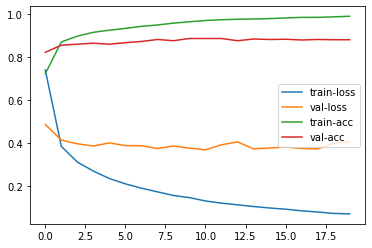

In [20]:
plt.plot(history_1.history['loss'], label='train-loss')
plt.plot(history_1.history['val_loss'], label='val-loss')
plt.plot(history_1.history['accuracy'], label='train-acc')
plt.plot(history_1.history['val_accuracy'], label='val-acc')
plt.legend()

In [21]:
score_mobile1 = mobile_1.evaluate(test_ds)[1]

27/27 [==============================] - 3s 106ms/step - loss: 0.4063 - accuracy: 0.8819


## TransferLearning Part 2 (Change the last Layer and add some dense/dropout layers too)

In [24]:
def Mobile_2(summary=False):
  mobile_model = MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=True)

  for layer in mobile_model.layers[:]:
      layer.trainable = False
  # this part is just like: mobile_model.trainable = False

  # last fully connected layer before Dense(1000) in image net
  output = output = mobile_model.layers[-2].output
  # output = layers.Flatten(name='new_flatten')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='first_new_fc')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='last_new_fc')(output)
  output = layers.Dropout(0.3)(output)
  output = layers.Dense(5, activation='softmax')(output)

  mobile_model = Model(mobile_model.input, output)
  mobile_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    print(mobile_model.summary())

  return mobile_model

In [25]:
mobile_2 = Mobile_2(summary=True)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [26]:
start_tra = perf_counter()
history_2 = mobile_2.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 21s 168ms/step - loss: 0.6839 - accuracy: 0.7793 - val_loss: 0.3796 - val_accuracy: 0.8588
Epoch 2/20
108/108 [==============================] - 14s 129ms/step - loss: 0.2592 - accuracy: 0.9088 - val_loss: 0.3547 - val_accuracy: 0.8773
Epoch 3/20
108/108 [==============================] - 14s 129ms/step - loss: 0.1255 - accuracy: 0.9600 - val_loss: 0.5144 - val_accuracy: 0.8565
Epoch 4/20
108/108 [==============================] - 14s 131ms/step - loss: 0.0910 - accuracy: 0.9687 - val_loss: 0.6378 - val_accuracy: 0.8391
Epoch 5/20
108/108 [==============================] - 14s 133ms/step - loss: 0.0887 - accuracy: 0.9690 - val_loss: 0.4671 - val_accuracy: 0.8773
Epoch 6/20
108/108 [==============================] - 14s 128ms/step - loss: 0.0653 - accuracy: 0.9780 - val_loss: 0.4769 - val_accuracy: 0.8796
Epoch 7/20
108/108 [==============================] - 14s 127ms/step - loss: 0.0387 - accuracy: 0.9873 - val_loss: 0.6365 - val_ac

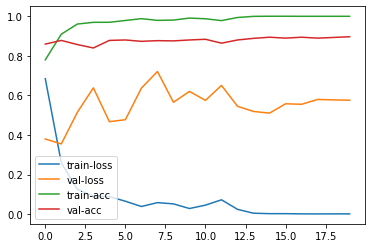

In [27]:
plt.plot(history_2.history['loss'], label='train-loss')
plt.plot(history_2.history['val_loss'], label='val-loss')
plt.plot(history_2.history['accuracy'], label='train-acc')
plt.plot(history_2.history['val_accuracy'], label='val-acc')
plt.legend()

In [28]:
score_mobile2 = mobile_2.evaluate(test_ds)[1]

27/27 [==============================] - 3s 104ms/step - loss: 0.5753 - accuracy: 0.8958


## TransferLearning Part 3 (Open the last trainable layers and add some dense/dropout layers)

In [29]:
def Mobile_3(summary=False):
  mobile_model = MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=True)

  for layer in mobile_model.layers[:]:
      layer.trainable = False
  # this part is just like: mobile_model.trainable = False

  # let the layers after last block anf fully connected layers be train
  set_trainable = False
  for lyr in mobile_model.layers:
    if lyr.name=='Conv_1':
      set_trainable=True
    lyr.trainable = set_trainable

  # last fully connected layer before Dense(1000) in image net
  output = output = mobile_model.layers[-2].output
  # output = layers.Flatten(name='new_flatten')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='first_new_fc')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='last_new_fc')(output)
  output = layers.Dropout(0.3)(output)
  output = layers.Dense(5, activation='softmax')(output)
  mobile_model = Model(mobile_model.input, output)

  mobile_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    print(mobile_model.summary())

  return mobile_model

In [30]:
mobile_3 = Mobile_3(summary=True)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [31]:
start_tra = perf_counter()
history_3 = mobile_3.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 17s 136ms/step - loss: 0.5976 - accuracy: 0.8120 - val_loss: 0.3761 - val_accuracy: 0.8819
Epoch 2/20
108/108 [==============================] - 14s 129ms/step - loss: 0.2515 - accuracy: 0.9131 - val_loss: 0.5070 - val_accuracy: 0.8507
Epoch 3/20
108/108 [==============================] - 14s 132ms/step - loss: 0.1459 - accuracy: 0.9418 - val_loss: 0.5721 - val_accuracy: 0.8623
Epoch 4/20
108/108 [==============================] - 16s 150ms/step - loss: 0.1310 - accuracy: 0.9595 - val_loss: 0.8639 - val_accuracy: 0.8218
Epoch 5/20
108/108 [==============================] - 15s 137ms/step - loss: 0.0785 - accuracy: 0.9754 - val_loss: 0.5410 - val_accuracy: 0.8924
Epoch 6/20
108/108 [==============================] - 14s 130ms/step - loss: 0.1142 - accuracy: 0.9725 - val_loss: 0.4998 - val_accuracy: 0.8692
Epoch 7/20
108/108 [==============================] - 15s 137ms/step - loss: 0.0794 - accuracy: 0.9739 - val_loss: 0.6334 - val_ac

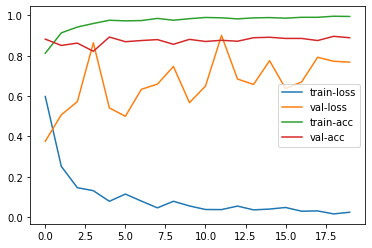

In [32]:
plt.plot(history_3.history['loss'], label='train-loss')
plt.plot(history_3.history['val_loss'], label='val-loss')
plt.plot(history_3.history['accuracy'], label='train-acc')
plt.plot(history_3.history['val_accuracy'], label='val-acc')
plt.legend()

In [33]:
score_mobile3 = mobile_3.evaluate(test_ds)[1]

27/27 [==============================] - 3s 105ms/step - loss: 0.7680 - accuracy: 0.8889


## TransterLearning Part 4 (Change Fully Connected Layers) 

In [34]:
# lest's first look at the MobileNetV2 architecture without fully Connected 
mobile_test = MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=False)
mobile_test.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

In [40]:
def Mobile_4(summary=False):
  mobile_model = MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=False)

  for layer in mobile_model.layers[:]:
      layer.trainable = False
  # this part is just like: mobile_model.trainable = False

  output = mobile_model.layers[-1].output
  output = layers.GlobalAveragePooling2D(name='global_avg_2d')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='fc1')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='fc2')(output)
  output = layers.Dropout(0.3)(output)
  output = layers.Dense(5, activation='softmax')(output)

  mobile_model = Model(mobile_model.input, output)
  mobile_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    print(mobile_model.summary())

  return mobile_model

In [43]:
mobile_4 = Mobile_4(summary=True)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [44]:
start_tra = perf_counter()
history_4 = mobile_4.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 67s 592ms/step - loss: 0.6176 - accuracy: 0.7883 - val_loss: 0.3911 - val_accuracy: 0.8565
Epoch 2/20
108/108 [==============================] - 14s 128ms/step - loss: 0.2897 - accuracy: 0.8978 - val_loss: 0.3967 - val_accuracy: 0.8785
Epoch 3/20
108/108 [==============================] - 14s 128ms/step - loss: 0.1601 - accuracy: 0.9435 - val_loss: 0.5851 - val_accuracy: 0.8310
Epoch 4/20
108/108 [==============================] - 14s 129ms/step - loss: 0.0928 - accuracy: 0.9681 - val_loss: 0.4384 - val_accuracy: 0.8866
Epoch 5/20
108/108 [==============================] - 14s 129ms/step - loss: 0.0671 - accuracy: 0.9768 - val_loss: 0.5626 - val_accuracy: 0.8623
Epoch 6/20
108/108 [==============================] - 14s 127ms/step - loss: 0.0532 - accuracy: 0.9849 - val_loss: 0.5253 - val_accuracy: 0.8738
Epoch 7/20
108/108 [==============================] - 14s 133ms/step - loss: 0.0362 - accuracy: 0.9887 - val_loss: 0.4719 - val_ac

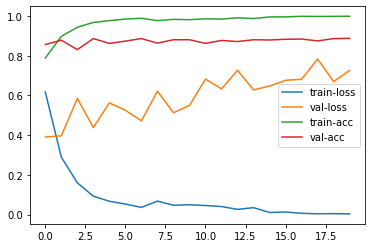

In [45]:
plt.plot(history_4.history['loss'], label='train-loss')
plt.plot(history_4.history['val_loss'], label='val-loss')
plt.plot(history_4.history['accuracy'], label='train-acc')
plt.plot(history_4.history['val_accuracy'], label='val-acc')
plt.legend()

In [46]:
score_mobile4 = mobile_4.evaluate(test_ds)[1]

27/27 [==============================] - 4s 139ms/step - loss: 0.7266 - accuracy: 0.8877


In [47]:
def anotherMobile_4(summary=False):

  mobile_model = MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=False)
  mobile_model.trainable = False

  inputs = layers.Input(shape=(224,224,3))
  x = mobile_model(inputs, training=False)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.Dropout(0.3)(x)
  prediction = layers.Dense(5, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=prediction)
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

  if summary:
    print(model.summary())

  return model

In [48]:
another_mobile_4 = anotherMobile_4(summary=True)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_6   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_11 (Dense)            (None, 1024)              1311744   
                                                                 
 dense_12 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_12 (Dropout)        (None, 1024)              0   

In [49]:
start_tra = perf_counter()
another_history_4 = another_mobile_4.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 18s 140ms/step - loss: 0.6069 - accuracy: 0.7932 - val_loss: 0.3996 - val_accuracy: 0.8623
Epoch 2/20
108/108 [==============================] - 15s 137ms/step - loss: 0.2679 - accuracy: 0.9067 - val_loss: 0.3934 - val_accuracy: 0.8657
Epoch 3/20
108/108 [==============================] - 15s 134ms/step - loss: 0.1504 - accuracy: 0.9427 - val_loss: 0.5049 - val_accuracy: 0.8565
Epoch 4/20
108/108 [==============================] - 14s 131ms/step - loss: 0.0974 - accuracy: 0.9684 - val_loss: 0.3729 - val_accuracy: 0.8808
Epoch 5/20
108/108 [==============================] - 14s 131ms/step - loss: 0.0630 - accuracy: 0.9786 - val_loss: 0.4334 - val_accuracy: 0.8924
Epoch 6/20
108/108 [==============================] - 14s 133ms/step - loss: 0.0458 - accuracy: 0.9861 - val_loss: 0.5072 - val_accuracy: 0.8877
Epoch 7/20
108/108 [==============================] - 14s 131ms/step - loss: 0.0657 - accuracy: 0.9768 - val_loss: 0.6674 - val_ac

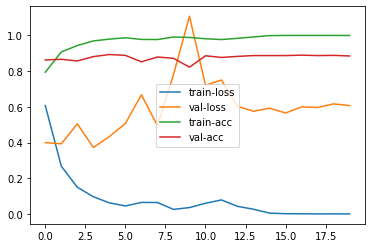

In [50]:
plt.plot(another_history_4.history['loss'], label='train-loss')
plt.plot(another_history_4.history['val_loss'], label='val-loss')
plt.plot(another_history_4.history['accuracy'], label='train-acc')
plt.plot(another_history_4.history['val_accuracy'], label='val-acc')
plt.legend()

In [51]:
another_score_mobile4 = another_mobile_4.evaluate(test_ds)[1]

27/27 [==============================] - 3s 104ms/step - loss: 0.6071 - accuracy: 0.8843


## TransferLearinig Part 5 (Open the last trainable layers before fully connected and add some dense/dropout layers)

In [55]:
def Mobile_5(summary=False):
  mobile_model = MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=False)

  for layer in mobile_model.layers[:]:
      layer.trainable = False
  # this part is just like: mobile_model.trainable = False

  # let the layers after last block be train
  set_trainable = False
  for lyr in mobile_model.layers:
    if lyr.name=='Conv_1':
      set_trainable=True
    lyr.trainable = set_trainable

  output = mobile_model.layers[-1].output
  output = layers.GlobalAveragePooling2D(name='glob_avg_2d')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='fc1')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='fc2')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='fc3')(output)
  output = layers.Dropout(0.3)(output)
  output = layers.Dense(5, activation='softmax')(output)

  mobile_model = Model(mobile_model.input, output)
  mobile_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    print(mobile_model.summary())

  return mobile_model

In [56]:
mobile_5 = Mobile_5(summary=True)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_15[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                          

In [57]:
start_tra = perf_counter()
history_5 = mobile_5.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 19s 143ms/step - loss: 0.6568 - accuracy: 0.7921 - val_loss: 0.5804 - val_accuracy: 0.8206
Epoch 2/20
108/108 [==============================] - 14s 131ms/step - loss: 0.2629 - accuracy: 0.9096 - val_loss: 0.6561 - val_accuracy: 0.8438
Epoch 3/20
108/108 [==============================] - 14s 132ms/step - loss: 0.1980 - accuracy: 0.9380 - val_loss: 0.8119 - val_accuracy: 0.7951
Epoch 4/20
108/108 [==============================] - 15s 139ms/step - loss: 0.1365 - accuracy: 0.9563 - val_loss: 0.7940 - val_accuracy: 0.8414
Epoch 5/20
108/108 [==============================] - 14s 132ms/step - loss: 0.1260 - accuracy: 0.9597 - val_loss: 0.4511 - val_accuracy: 0.8727
Epoch 6/20
108/108 [==============================] - 14s 132ms/step - loss: 0.0879 - accuracy: 0.9696 - val_loss: 0.6646 - val_accuracy: 0.8681
Epoch 7/20
108/108 [==============================] - 15s 139ms/step - loss: 0.0944 - accuracy: 0.9699 - val_loss: 0.5211 - val_ac

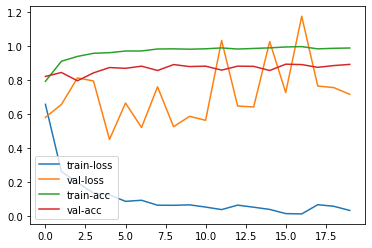

In [58]:
plt.plot(history_5.history['loss'], label='train-loss')
plt.plot(history_5.history['val_loss'], label='val-loss')
plt.plot(history_5.history['accuracy'], label='train-acc')
plt.plot(history_5.history['val_accuracy'], label='val-acc')
plt.legend()

In [59]:
score_mobile5 = mobile_5.evaluate(test_ds)[1]

27/27 [==============================] - 3s 105ms/step - loss: 0.7157 - accuracy: 0.8912


In [60]:
def anotherMobile_5(summary=False):

  mobile_model = MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=False)
  mobile_model.trainable = False

  # let the layers after last block be train
  set_trainable = False
  for lyr in mobile_model.layers:
    if lyr.name=='Conv_1':
      set_trainable=True
    lyr.trainable = set_trainable

  inputs = layers.Input(shape=(224,224,3))
  x = mobile_model(inputs, training=False)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.Dropout(0.3)(x)
  prediction = layers.Dense(5, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=prediction)
  model.compile(optimizer=keras.optimizers.Adam(1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

  if summary:
    print(model.summary())

  return model

In [61]:
another_mobile_5 = anotherMobile_5(summary=True)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_7   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_16 (Dense)            (None, 1024)              1311744   
                                                                 
 dense_17 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_15 (Dropout)        (None, 1024)              0  

In [62]:
start_tra = perf_counter()
another_history_5 = another_mobile_5.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 18s 144ms/step - loss: 1.4613 - accuracy: 0.3976 - val_loss: 0.9838 - val_accuracy: 0.6632
Epoch 2/20
108/108 [==============================] - 14s 130ms/step - loss: 0.9259 - accuracy: 0.6481 - val_loss: 0.7357 - val_accuracy: 0.7569
Epoch 3/20
108/108 [==============================] - 14s 128ms/step - loss: 0.7227 - accuracy: 0.7347 - val_loss: 0.6235 - val_accuracy: 0.8021
Epoch 4/20
108/108 [==============================] - 14s 129ms/step - loss: 0.6054 - accuracy: 0.7926 - val_loss: 0.5548 - val_accuracy: 0.8160
Epoch 5/20
108/108 [==============================] - 14s 131ms/step - loss: 0.5375 - accuracy: 0.8164 - val_loss: 0.5144 - val_accuracy: 0.8310
Epoch 6/20
108/108 [==============================] - 14s 134ms/step - loss: 0.4887 - accuracy: 0.8306 - val_loss: 0.4809 - val_accuracy: 0.8414
Epoch 7/20
108/108 [==============================] - 15s 138ms/step - loss: 0.4473 - accuracy: 0.8451 - val_loss: 0.4628 - val_ac

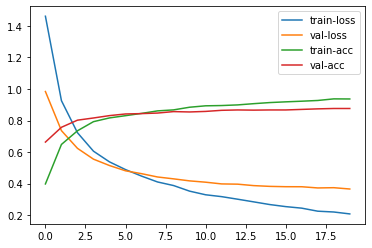

In [63]:
plt.plot(another_history_5.history['loss'], label='train-loss')
plt.plot(another_history_5.history['val_loss'], label='val-loss')
plt.plot(another_history_5.history['accuracy'], label='train-acc')
plt.plot(another_history_5.history['val_accuracy'], label='val-acc')
plt.legend()

In [64]:
another_score_mobile5 = another_mobile_5.evaluate(test_ds)[1]

27/27 [==============================] - 3s 104ms/step - loss: 0.3655 - accuracy: 0.8762


In [65]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2)])
mobile_preprocess = preprocess_input

In [76]:
def lastMobile_5(summary=False):

  mobile_model = MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=False)
  mobile_model.trainable = False

  # let the layers after last block be train
  set_trainable = False
  for lyr in mobile_model.layers:
    if lyr.name=='block_6_expand':
      set_trainable=True
    lyr.trainable = set_trainable

  inputs = layers.Input(shape=(224,224,3))
  x = data_augmentation(inputs)
  x = mobile_preprocess(x)
  x = mobile_model(inputs, training=False)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.Dropout(0.3)(x)
  prediction = layers.Dense(5, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=prediction)
  model.compile(optimizer=keras.optimizers.Adam(1e-2),loss='categorical_crossentropy',metrics=['accuracy'])

  if summary:
    print(model.summary())

  return model

In [77]:
last_mobile_5 = lastMobile_5(summary=True)

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_9   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_25 (Dense)            (None, 1024)              1311744   
                                                                 
 dense_26 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_18 (Dropout)        (None, 1024)              0  

In [78]:
start_tra = perf_counter()
last_history_5 = last_mobile_5.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 18s 145ms/step - loss: 2.2947 - accuracy: 0.7501 - val_loss: 0.4366 - val_accuracy: 0.8461
Epoch 2/20
108/108 [==============================] - 14s 128ms/step - loss: 0.4122 - accuracy: 0.8572 - val_loss: 0.4033 - val_accuracy: 0.8588
Epoch 3/20
108/108 [==============================] - 14s 127ms/step - loss: 0.3204 - accuracy: 0.8966 - val_loss: 0.3985 - val_accuracy: 0.8553
Epoch 4/20
108/108 [==============================] - 14s 134ms/step - loss: 0.2785 - accuracy: 0.9117 - val_loss: 0.5661 - val_accuracy: 0.8356
Epoch 5/20
108/108 [==============================] - 14s 127ms/step - loss: 0.2611 - accuracy: 0.9143 - val_loss: 0.6542 - val_accuracy: 0.8206
Epoch 6/20
108/108 [==============================] - 14s 126ms/step - loss: 0.2429 - accuracy: 0.9250 - val_loss: 0.5987 - val_accuracy: 0.8322
Epoch 7/20
108/108 [==============================] - 14s 133ms/step - loss: 0.2015 - accuracy: 0.9374 - val_loss: 0.5315 - val_ac

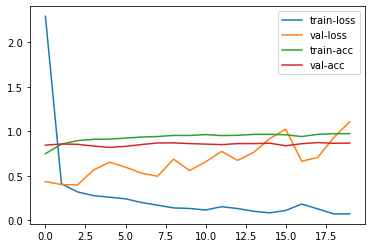

In [79]:
plt.plot(last_history_5.history['loss'], label='train-loss')
plt.plot(last_history_5.history['val_loss'], label='val-loss')
plt.plot(last_history_5.history['accuracy'], label='train-acc')
plt.plot(last_history_5.history['val_accuracy'], label='val-acc')
plt.legend()

In [80]:
last_score_mobile5 = last_mobile_5.evaluate(test_ds)[1]

27/27 [==============================] - 3s 103ms/step - loss: 1.1105 - accuracy: 0.8692


##Feature Extraction

In [81]:
model = MobileNetV2(weights='imagenet',
              include_top=False,
              input_shape=(224, 224, 3))
model.summary()
# model.trainable = False

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_24[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [85]:
datagenerator = ImageDataGenerator(rescale=1./255)

def feature_extractor(sample_size, batch_size, data_frame):
  features = np.zeros((sample_size, 7, 7, 1280))
  labels = np.zeros((sample_size,5))
  datagen = datagenerator.flow_from_dataframe(data_frame,
                                            x_col='Filepath',
                                            y_col='Label',
                                            target_size=(224, 224),
                                            color_mode='rgb',
                                            class_mode='categorical',
                                            batch_size=32)
  cnt = 0 
  for input_pxl, lbl in datagen:
    features_batch = model.predict(input_pxl)
    features[cnt * batch_size : (cnt+1) * batch_size] = features_batch
    labels[cnt * batch_size : (cnt+1) * batch_size] = lbl
    cnt += 1
    if cnt * batch_size > sample_size:
      break
    

  return features, labels

In [86]:
train_ds, test_ds = train_test_split(image_df, test_size=0.1, random_state=1)

In [87]:
train_features, train_labels = feature_extractor(len(train_ds), batch_size=32, data_frame=train_ds)
test_features, test_labels = feature_extractor(len(test_ds), batch_size=32, data_frame=test_ds)

Found 3885 validated image filenames belonging to 5 classes.
1/1 [==============================] - 1s 989ms/step
Found 432 validated image filenames belonging to 5 classes.
1/1 [==============================] - 0s 340ms/step


*First train a neural network with these features*

In [89]:
train_features = train_features.reshape(-1, 7*7*1280)
test_features = test_features.reshape(-1, 7*7*1280)

n_features = (train_features.shape[1])
input = layers.Input(shape=n_features)

layer1 = layers.Dense(512, activation='relu', kernel_initializer='he_normal')(input)
layer2 = layers.BatchNormalization()(layer1)
layer3 = layers.Dropout(0.5)(layer2)

output = layers.Dense(5, activation='softmax')(layer3)

model = Model(input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [90]:
history_f = model.fit(train_features, train_labels,epochs=20 ,batch_size=65, validation_data=(test_features,test_labels))

Epoch 1/20
60/60 [==============================] - 2s 22ms/step - loss: 0.6321 - accuracy: 0.8103 - val_loss: 0.4329 - val_accuracy: 0.8819
Epoch 2/20
60/60 [==============================] - 1s 18ms/step - loss: 0.1738 - accuracy: 0.9385 - val_loss: 0.3263 - val_accuracy: 0.8958
Epoch 3/20
60/60 [==============================] - 1s 17ms/step - loss: 0.0638 - accuracy: 0.9835 - val_loss: 0.3234 - val_accuracy: 0.9028
Epoch 4/20
60/60 [==============================] - 1s 18ms/step - loss: 0.0418 - accuracy: 0.9902 - val_loss: 0.3682 - val_accuracy: 0.8866
Epoch 5/20
60/60 [==============================] - 1s 21ms/step - loss: 0.0218 - accuracy: 0.9964 - val_loss: 0.3117 - val_accuracy: 0.8981
Epoch 6/20
60/60 [==============================] - 1s 22ms/step - loss: 0.0176 - accuracy: 0.9974 - val_loss: 0.3045 - val_accuracy: 0.9005
Epoch 7/20
60/60 [==============================] - 1s 18ms/step - loss: 0.0121 - accuracy: 0.9982 - val_loss: 0.3294 - val_accuracy: 0.9005
Epoch 8/20
60

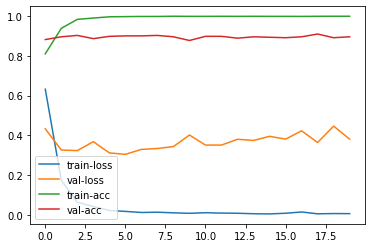

In [91]:
plt.plot(history_f.history['loss'], label='train-loss')
plt.plot(history_f.history['val_loss'], label='val-loss')
plt.plot(history_f.history['accuracy'], label='train-acc')
plt.plot(history_f.history['val_accuracy'], label='val-acc')
plt.legend()

*Now we train a svm model with extracted features*

In [92]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
clsfier = SVC(C=1, kernel='rbf')
clsfier.fit(train_features, np.argmax(train_labels, axis=1))
prediction = clsfier.predict(test_features)
print(classification_report(np.argmax(test_labels, axis=1), prediction))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88        81
           1       0.90      0.95      0.92        92
           2       0.84      0.97      0.90        76
           3       0.91      0.77      0.84        79
           4       0.89      0.91      0.90       104

    accuracy                           0.89       432
   macro avg       0.89      0.89      0.89       432
weighted avg       0.89      0.89      0.89       432

